#Challenge Steps

In [ ]:
#mount to drive to not lose the progress
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!nvidia-smi

Sun Nov 24 23:46:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!sudo apt-get update
!sudo apt-get install -y libxrender1

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libxrender1 is already the newest version (1:0.9.10-1build4).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA available: True
Device name: Tesla T4


In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Import needed libraries
!pip install rdkit-pypi
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install seaborn
!pip install numpy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
from rdkit.Chem import AllChem, Descriptors
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.5 MB/s eta 0:00:00


#1- Data Import and Normalization

In [ ]:

# #Generate a dataset

# # Function to generate valid molecules and calculate properties
# def generate_molecule_data(num_molecules=5000):
#     data = []
#     for _ in range(num_molecules):
#         try:
#             # Generate a random molecule
#             mol = Chem.RWMol()
#             num_atoms = random.randint(3, 10)
#             for _ in range(num_atoms):
#                 atom = Chem.Atom(random.choice(["C", "O", "N", "H"]))
#                 mol.AddAtom(atom)
#             for i in range(num_atoms - 1):
#                 mol.AddBond(i, i + 1, random.choice([Chem.BondType.SINGLE, Chem.BondType.DOUBLE]))

#             mol = mol.GetMol()
#             Chem.SanitizeMol(mol)
#             smiles = Chem.MolToSmiles(mol)

#             # Calculate properties
#             logP = Descriptors.MolLogP(mol)
#             logS = -Descriptors.MolMR(mol) / Descriptors.MolWt(mol)  # Solubility proxy
#             mol_wt = Descriptors.MolWt(mol)
#             tpsa = Descriptors.TPSA(mol)

#             data.append({"SMILES": smiles, "LogP": round(logP, 2), "LogS": round(logS, 3),
#                          "MolWt": round(mol_wt, 2), "TPSA": round(tpsa, 2)})
#         except Exception as e:
#             # Skip invalid molecules
#             pass
#     return pd.DataFrame(data)

# # Generate the dataset
# molecule_data = generate_molecule_data()

# # Save to CSV
# output_path = "Data3.csv"
# molecule_data.to_csv(output_path, index=False)

# print(f"Dataset saved to {output_path}")


In [ ]:
#import the dataset file
datasetName =  "LogP_LogS.csv"

# Load the CSV data into a pandas DataFrame
data = pd.read_csv(datasetName)

# Display the first few rows of the data
print(data.head())

  Compound ID                     InChIKey  \
0       C1711  ACTIUHUUMQJHFO-UPTCCGCDSA-N   
1       C1712  CQISYTXUORWJSX-UHFFFAOYSA-N   
2       C1713  UXPYIAWFQKSHNV-UHFFFAOYSA-N   
3       C1714  BDIWFCKBPZPBQT-UHFFFAOYSA-N   
4       C1715  RNPXCFINMKSQPQ-UHFFFAOYSA-N   

                                              SMILES       logS     logP  \
0  COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C... -18.217693  17.8539   
1  CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC... -17.468457  14.2326   
2     CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC -16.259392  11.8156   
3          CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC -15.676287  10.4112   
4         CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O -15.205120  12.0826   

        MW  
0  863.344  
1  641.065  
2  566.939  
3  612.153  
4  546.846  


In [ ]:
# Create a new column 'class' to mark highlighted molecules
data['class'] = 0  # Initialize all as 0
data.loc[
    (data['logP'] >= 1.5) & (data['logP'] <= 3.5) & (data['logS'] > -4),
    'class'
] = 1  # Mark molecules in the specified range as 1


# Save the groups into separate CSV files
highlighted_data = data[data['class'] == 1]
non_highlighted_data = data[data['class'] == 0]

# Save the files
highlighted_data.to_csv('highlighted_molecules.csv', index=False)
non_highlighted_data.to_csv('non_highlighted_molecules.csv', index=False)

# Save the entire dataset with the new 'class' column
data.to_csv('full_dataset_with_class.csv', index=False)

# Print confirmation
print("Files saved:")
print("1. Highlighted molecules: highlighted_molecules.csv")
print("2. Non-highlighted molecules: non_highlighted_molecules.csv")
print("3. Full dataset with 'class' column: full_dataset_with_class.csv")

Files saved:
1. Highlighted molecules: highlighted_molecules.csv
2. Non-highlighted molecules: non_highlighted_molecules.csv
3. Full dataset with 'class' column: full_dataset_with_class.csv


In [ ]:
!pip install transformers datasets torch rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


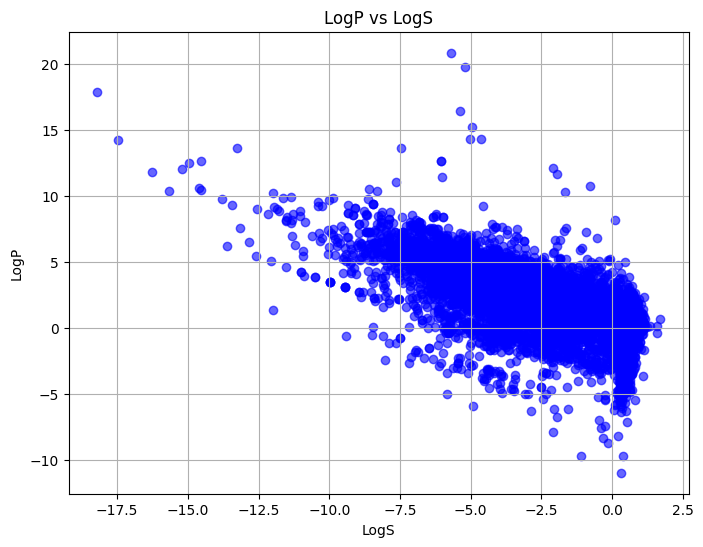

In [ ]:
# Plot LogS vs LogP
plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(data['logS'], data['logP'], color='blue', alpha=0.6)

# Add labels and title
plt.xlabel('LogS')  # X-axis label
plt.ylabel('LogP')  # Y-axis label
plt.title('LogP vs LogS')  # Plot title

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Normalize LogP and LogS using Min-Max scaling
data['LogP_normalized'] = (data['logP'] - data['logP'].min()) / (data['logP'].max() - data['logP'].min())
data['LogS_normalized'] = (data['logS'] - data['logS'].min()) / (data['logS'].max() - data['logS'].min())

# Display the first few rows to verify
print(data[['SMILES', 'logP', 'LogP_normalized', 'logS', 'LogS_normalized']].head())


                                              SMILES     logP  \
0  COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...  17.8539   
1  CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...  14.2326   
2     CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC  11.8156   
3          CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC  10.4112   
4         CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O  12.0826   

   LogP_normalized       logS  LogS_normalized  
0         0.905604 -18.217693         0.000000  
1         0.791685 -17.468457         0.037617  
2         0.715651 -16.259392         0.098320  
3         0.671471 -15.676287         0.127595  
4         0.724050 -15.205120         0.151251  


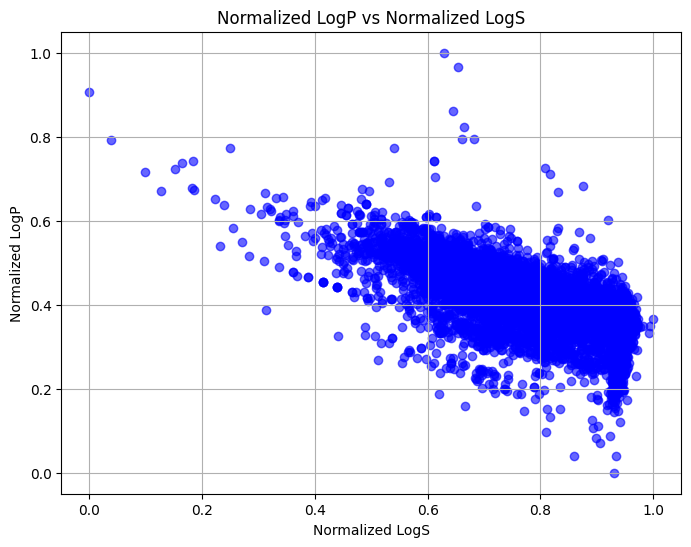

In [ ]:

# Plot normalized LogS vs normalized LogP
plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(data['LogS_normalized'], data['LogP_normalized'], color='blue', alpha=0.6)

# Add labels and title
plt.xlabel('Normalized LogS')  # X-axis label
plt.ylabel('Normalized LogP')  # Y-axis label
plt.title('Normalized LogP vs Normalized LogS')  # Plot title

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


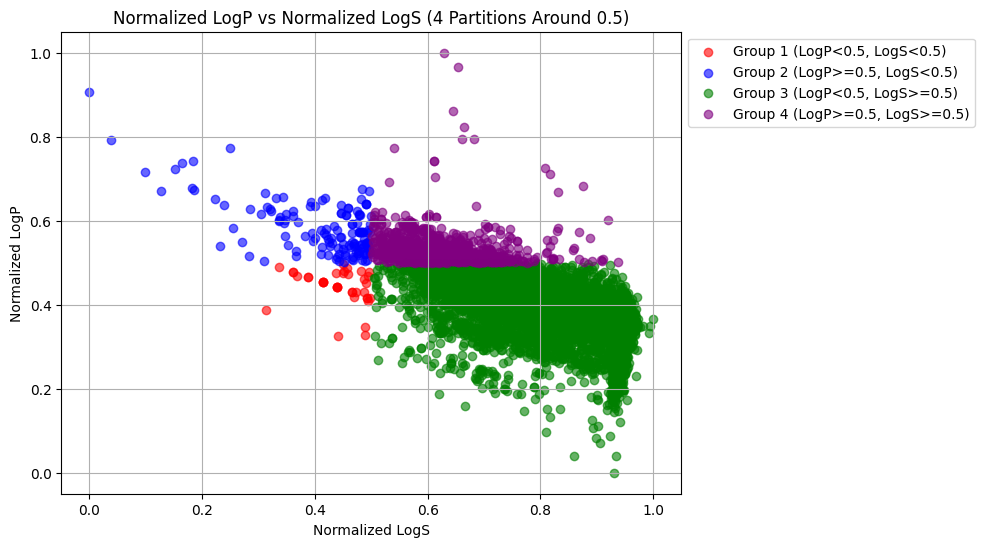

In [ ]:
#Partition the Data: Divide the plot into 4 partitions around the value 0.5

# Define the thresholds for LogP and LogS
logP_threshold = 0.5
logS_threshold = 0.5

# Categorize molecules into 4 groups based on LogP and LogS
conditions = [
    (data['LogP_normalized'] < logP_threshold) & (data['LogS_normalized'] < logS_threshold),  # Group 1
    (data['LogP_normalized'] >= logP_threshold) & (data['LogS_normalized'] < logS_threshold),  # Group 2
    (data['LogP_normalized'] < logP_threshold) & (data['LogS_normalized'] >= logS_threshold),  # Group 3
    (data['LogP_normalized'] >= logP_threshold) & (data['LogS_normalized'] >= logS_threshold)   # Group 4
]

# Assign colors for each group
colors = ['red', 'blue', 'green', 'purple']
group_labels = ['Group 1 (LogP<0.5, LogS<0.5)', 'Group 2 (LogP>=0.5, LogS<0.5)', 'Group 3 (LogP<0.5, LogS>=0.5)', 'Group 4 (LogP>=0.5, LogS>=0.5)']

# Create a new column for the group categories
data['Group'] = np.select(conditions, group_labels, default='None')

# Plot the data with different colors for each group
plt.figure(figsize=(8, 6))

# Plot each group with a different color
for i, label in enumerate(group_labels):
    group_data = data[data['Group'] == label]
    plt.scatter(group_data['LogS_normalized'], group_data['LogP_normalized'],
                label=label, color=colors[i], alpha=0.6)

# Add labels and title
plt.xlabel('Normalized LogS')
plt.ylabel('Normalized LogP')
plt.title('Normalized LogP vs Normalized LogS (4 Partitions Around 0.5)')

# Add grid for better readability
plt.grid(True)

# Add legend outside the plot area to avoid overlap
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Show the plot
plt.show()

In [ ]:
# Save each group to a CSV file with simple filenames
for i, label in enumerate(data['Group'].unique(), start=1):
    group_data = data[data['Group'] == label]

    # Create a simple filename based on the group number
    filename = f"Group{i}.csv"

    # Save the group data to a CSV file
    group_data.to_csv(filename, index=False)

    print(f"Saved {label} data to {filename}")

Saved Group 2 (LogP>=0.5, LogS<0.5) data to Group1.csv
Saved Group 1 (LogP<0.5, LogS<0.5) data to Group2.csv
Saved Group 4 (LogP>=0.5, LogS>=0.5) data to Group3.csv
Saved Group 3 (LogP<0.5, LogS>=0.5) data to Group4.csv


In [ ]:
# Count the number of molecules in each group
group_counts = data['Group'].value_counts()

# Display the result
print("Number of molecules in each group:")
print(group_counts)

# Find the largest group
largest_group = group_counts.idxmax()  # Group with the maximum count
largest_group_count = group_counts.max()  # Number of molecules in the largest group

# Display the largest group and its count
print(f"The largest group is {largest_group} with {largest_group_count} molecules.")



Number of molecules in each group:
Group
Group 3 (LogP<0.5, LogS>=0.5)     8856
Group 4 (LogP>=0.5, LogS>=0.5)     908
Group 2 (LogP>=0.5, LogS<0.5)      141
Group 1 (LogP<0.5, LogS<0.5)        38
Name: count, dtype: int64
The largest group is Group 3 (LogP<0.5, LogS>=0.5) with 8856 molecules.


#2: Tanimoto Similarity Analysis

Processing Group 1...


/tmp/ipykernel_7191/3218867664.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(distance_matrix, method='ward')


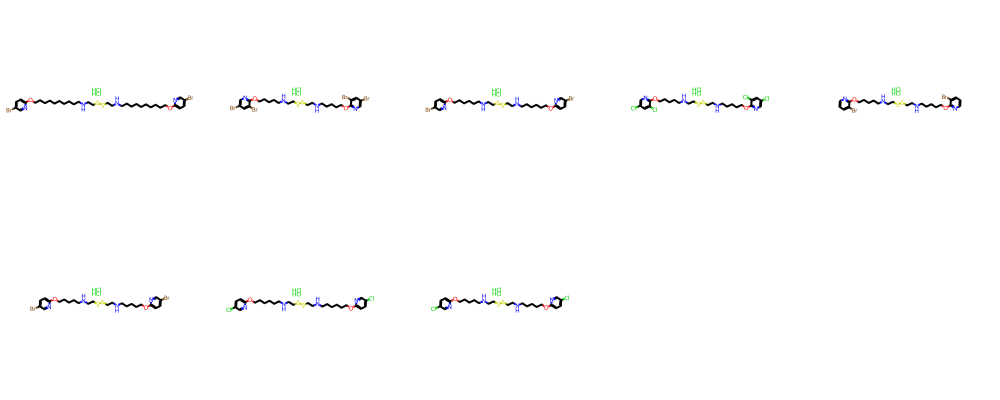

Group 1: Most similar cluster contains 8 molecules.
Cluster categorization saved to group1_clusters.csv

Processing Group 2...


/tmp/ipykernel_7191/3218867664.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(distance_matrix, method='ward')


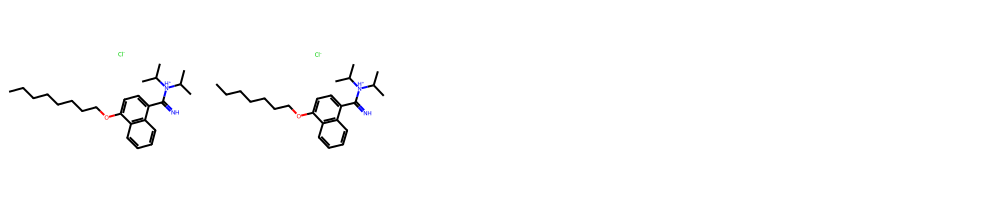

Group 2: Most similar cluster contains 2 molecules.
Cluster categorization saved to group2_clusters.csv

Processing Group 3...


/tmp/ipykernel_7191/3218867664.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(distance_matrix, method='ward')


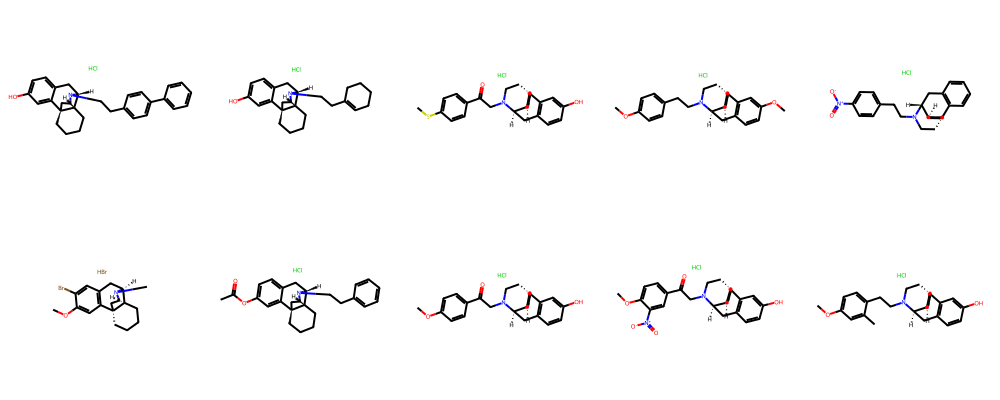

Group 3: Most similar cluster contains 41 molecules.
Cluster categorization saved to group3_clusters.csv

Processing Group 4...


/tmp/ipykernel_7191/3218867664.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(distance_matrix, method='ward')


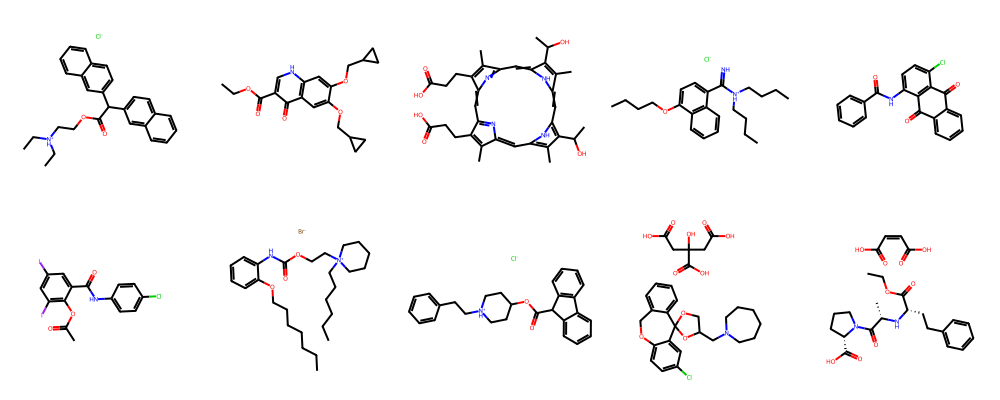

Group 4: Most similar cluster contains 2466 molecules.
Cluster categorization saved to group4_clusters.csv



In [ ]:
# Load grouped CSV files
group_files = ["Group1.csv", "Group2.csv", "Group3.csv", "Group4.csv"]
groups = [pd.read_csv(file) for file in group_files]

# Function to generate fingerprints
def generate_fingerprints(smiles_list):
    return [
        AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=2048)
        for smiles in smiles_list
    ]


# Function to compute the Tanimoto similarity matrix using vectorized operations
def compute_similarity_matrix(fingerprints):
    n = len(fingerprints)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        similarity_matrix[i, i:] = [
            FingerprintSimilarity(fingerprints[i], fingerprints[j]) for j in range(i, n)
        ]
    # Make the matrix symmetric
    similarity_matrix += np.triu(similarity_matrix, 1).T
    return similarity_matrix

# Calculate similarity for each group
for i, group in enumerate(groups):
    print(f"Processing Group {i+1}...")

    # Generate fingerprints for the group
    fingerprints = generate_fingerprints(group['SMILES'])

    # Compute similarity matrix
    similarity_matrix = compute_similarity_matrix(fingerprints)

    # Perform hierarchical clustering
    distance_matrix = 1 - similarity_matrix
    Z = sch.linkage(distance_matrix, method='ward')
    clusters = fcluster(Z, t=5, criterion='maxclust')  #We can adjust 't' as needed

    # Assign cluster labels to molecules
    group['Cluster'] = clusters

    # Find the most similar category (cluster with highest similarity)
    cluster_similarities = {}
    for cluster_id in np.unique(clusters):
        indices = group[group['Cluster'] == cluster_id].index
        avg_similarity = similarity_matrix[np.ix_(indices, indices)].mean()
        cluster_similarities[cluster_id] = avg_similarity

    most_similar_cluster = max(cluster_similarities, key=cluster_similarities.get)
    most_similar_molecules = group[group['Cluster'] == most_similar_cluster]

    # Draw up to 10 molecules from the most similar category
    mols = [
        Chem.MolFromSmiles(smiles)
        for smiles in most_similar_molecules['SMILES'].head(10)
    ]
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
    display(img)

    # Save cluster data for this group
    group.to_csv(f"group{i+1}_clusters.csv", index=False)

    # Print summary
    print(f"Group {i+1}: Most similar cluster contains {len(most_similar_molecules)} molecules.")
    print(f"Cluster categorization saved to group{i+1}_clusters.csv\n")


#3. Fine-Tuning with ChemBERT

#1- Installing needed packeges, loading the data and the Pre-trained Model

In [ ]:
# Install necessary libraries
!pip install transformers torch rdkit pandas
!pip install scikit-learn
import pandas as pd
from transformers import AutoTokenizer
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

In [ ]:
# Load the LogP-LogS dataset
logp_logs_df = pd.read_csv("LogP_LogS.csv")

# Normalize the labels
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# logp_logs_df[['logP', 'logS']] = scaler.fit_transform(logp_logs_df[['logP', 'logS']])

# Split the dataset into training and validation sets
train_df, valid_df = train_test_split(logp_logs_df, test_size=0.2, random_state=42)


# Verify structure
print(train_df.head())


     Compound ID                     InChIKey  \
715        C2297  OSQHGAXCVAYZPZ-UHFFFAOYSA-K   
809        C2382  GIZKPGCNANMOKF-CZPWWGKQSA-N   
6481       C7100  HUUKPCNVNYZLFY-UHFFFAOYSA-N   
7533       C7948  ADNAPRCXSGMYRO-UHFFFAOYSA-N   
6436       C7059  IJKAOMCJQZGZPQ-UHFFFAOYSA-N   

                                                 SMILES      logS    logP  \
715   [O-]C(=O)c1ccccc1Nc1cccc(c1)C(F)(F)F.[O-]C(=O)... -6.224020  8.6565   
809   O[C@H]([C@H](C(=O)O)O)C(=O)O.COc1ccc2c(c1)[C@]... -6.054767  2.8116   
6481                             CN1C2CCC(C2)C(C1C)(C)C -2.035965  2.4531   
7533                                      CCC(C#C)(OC)C -1.420475  1.4347   
6436             CN(CCOC(=O)C(c1ccccc1)(c1ccccc1)O)C.Cl -2.056295  2.8293   

           MW  
715   867.647  
809   511.607  
6481  167.291  
7533  112.170  
6436  335.825  


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True
Device name: Tesla T4


In [ ]:
# Define a Custom Dataset Class

class MoleculeDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        smiles = row['SMILES']
        logp = row['logP']  # First label
        # logs = row['logS']  # Second label

        # Tokenize SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor([logp], dtype=torch.float)  # Multi-label
        }


In [ ]:
#Load ChemBERTa Model and Tokenizer

# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MLM")

# Load pre-trained ChemBERTa model
modelp = AutoModelForSequenceClassification.from_pretrained(
    "DeepChem/ChemBERTa-10M-MLM",
    num_labels=1  # Output two labels: LogP and LogS
)

modelp = modelp.to(device)

pytorch_model.bin:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Create DataLoaders
# # Normalize LogP and LogS using Min-Max scaling for better training performence
# train_df['LogP_normalized'] = (train_df['logP'] - train_df['logP'].min()) / (train_df['logP'].max() - train_df['logP'].min())
# train_df['LogS_normalized'] = (train_df['logS'] - train_df['logS'].min()) / (train_df['logS'].max() - train_df['logS'].min())


# valid_df['LogP_normalized'] = (valid_df['logP'] - valid_df['logP'].min()) / (valid_df['logP'].max() - valid_df['logP'].min())
# valid_df['LogS_normalized'] = (valid_df['logS'] - valid_df['logS'].min()) / (valid_df['logS'].max() - valid_df['logS'].min())


# Create dataset instances
train_dataset = MoleculeDataset(train_df, tokenizer, max_length=128)
valid_dataset = MoleculeDataset(valid_df, tokenizer, max_length=128)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

#2- Fine-tune the Model



In [ ]:
# Define optimizer and loss function

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5) #1e-4 #5e-5 #6e-5

# Define scheduler
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Define loss function
import torch
import torch.nn as nn

loss_fn = nn.MSELoss()


NameError: name 'model' is not defined

In [ ]:
from tqdm import tqdm
from sklearn.metrics import r2_score

epochs = 20
train_losses = []
r2_scores = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits.squeeze(), labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # Accumulate training loss
        train_loss += loss.item()

        # Store predictions and true labels for accuracy calculation
        all_preds.extend(logits.squeeze().detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    # Compute average loss for the epoch
    avg_loss = train_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Calculate R² accuracy
    r2 = r2_score(all_labels, all_preds)
    r2_scores.append(r2)

    print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}, R²: {r2:.4f}")


Epoch 1/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:07<00:00,  7.36it/s]


Epoch 1 - Training Loss: 1.2373, R²: 0.7518
Epoch 2/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:09<00:00,  7.12it/s]


Epoch 2 - Training Loss: 1.0709, R²: 0.7855
Epoch 3/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:10<00:00,  7.07it/s]


Epoch 3 - Training Loss: 1.0643, R²: 0.7870
Epoch 4/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:13<00:00,  6.76it/s]


Epoch 4 - Training Loss: 1.0542, R²: 0.7907
Epoch 5/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:09<00:00,  7.12it/s]


Epoch 5 - Training Loss: 1.0564, R²: 0.7879
Epoch 6/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:15<00:00,  6.62it/s]


Epoch 6 - Training Loss: 1.0590, R²: 0.7879
Epoch 7/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:14<00:00,  6.71it/s]


Epoch 7 - Training Loss: 1.0436, R²: 0.7908
Epoch 8/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:15<00:00,  6.59it/s]


Epoch 8 - Training Loss: 1.0414, R²: 0.7909
Epoch 9/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:14<00:00,  6.72it/s]


Epoch 9 - Training Loss: 1.0440, R²: 0.7904
Epoch 10/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:13<00:00,  6.79it/s]


Epoch 10 - Training Loss: 1.0559, R²: 0.7878
Epoch 11/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:11<00:00,  6.94it/s]


Epoch 11 - Training Loss: 1.0409, R²: 0.7909
Epoch 12/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:13<00:00,  6.77it/s]


Epoch 12 - Training Loss: 1.0462, R²: 0.7902
Epoch 13/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:15<00:00,  6.61it/s]


Epoch 13 - Training Loss: 1.0442, R²: 0.7903
Epoch 14/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:14<00:00,  6.71it/s]


Epoch 14 - Training Loss: 1.0538, R²: 0.7883
Epoch 15/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:11<00:00,  6.93it/s]


Epoch 15 - Training Loss: 1.0445, R²: 0.7904
Epoch 16/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:13<00:00,  6.74it/s]


Epoch 16 - Training Loss: 1.0405, R²: 0.7911
Epoch 17/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:15<00:00,  6.62it/s]


Epoch 17 - Training Loss: 1.0522, R²: 0.7894
Epoch 18/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:14<00:00,  6.66it/s]


Epoch 18 - Training Loss: 1.0507, R²: 0.7888
Epoch 19/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:11<00:00,  6.94it/s]


Epoch 19 - Training Loss: 1.0393, R²: 0.7912
Epoch 20/20


100%|███████████████████████████████████████████████████████████████████████| 498/498 [01:16<00:00,  6.53it/s]


Epoch 20 - Training Loss: 1.0578, R²: 0.7881


In [ ]:
# Save the full model
torch.save(model, "fine-tuned-chemberta.pth")

# Load the full model
# model = torch.load("fine-tuned-chemberta.pth")
# model.eval()


#3- Evaluate the Model

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score

# Define the MSE loss function
loss_fn = nn.MSELoss()

# Assuming you already have your model and test data loaded
# Here, we will loop through the validation/test data, compute predictions, and calculate the loss

model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []
total_loss = 0

with torch.no_grad():  # No need to compute gradients during evaluation
    for batch in tqdm(valid_loader):  # Replace 'valid_loader' with your validation dataloader
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits  # Get predictions (LogP, LogS)

        # Calculate the loss (MSE)
        loss = loss_fn(preds, labels)
        total_loss += loss.item()

        # Store predictions and true labels for further evaluation (like R²)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average loss
avg_loss = total_loss / len(valid_loader)

# Optionally calculate R² score
r2 = r2_score(all_labels, all_preds)

# Print results
print(f"Validation Loss (MSE): {avg_loss:.4f}")
print(f"R² Score: {r2:.4f}")




100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 28.00it/s]

Validation Loss (MSE): 1.0755
R² Score: 0.7911


In [ ]:
# Testing with the four groups
#loading the groups into dataframes
group1_df = pd.read_csv("Group1.csv")
group2_df = pd.read_csv("Group2.csv")
group3_df = pd.read_csv("Group3.csv")
group4_df = pd.read_csv("Group4.csv")

group_datasets = [MoleculeDataset(group_df, tokenizer, max_length=128) for group_df in [group1_df, group2_df, group3_df, group4_df]]
group_loaders = [DataLoader(dataset, batch_size=16) for dataset in group_datasets]


# Assuming you have your model, loss_fn (e.g., MSELoss), and group_loaders prepared

for i, loader in enumerate(group_loaders):  # Loop through each group
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()  # Get the predicted LogP and LogS values

            # Compute regression loss (e.g., MSELoss)
            loss = loss_fn(preds, labels)
            total_loss += loss.item()

            # Store predictions and true labels for further evaluation (like R²)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


            # Calculate Mean Squared Error (MSE)
            # correct += ((preds - labels) ** 2).sum().item()  # Sum of squared errors
            # total += labels.size(0)

    # Calculate the average loss and MSE for the group
    avg_loss = total_loss / len(loader)
    #mse = correct / total  # Mean Squared Error

    # Optionally calculate R² score
    r2 = r2_score(all_labels, all_preds)
    # Print results
    print(f"Validation Loss (MSE): {avg_loss:.4f}")
    print(f"R² Score: {r2:.4f}")

    # print(f"Group {i + 1} - Test Loss: {avg_loss:.4f}, Test MSE: {mse:.4f}")


Validation Loss (MSE): 9.3117
R² Score: 0.7861
Validation Loss (MSE): 5.5837
R² Score: 0.7834
Validation Loss (MSE): 1.5702
R² Score: 0.7808
Validation Loss (MSE): 0.7486
R² Score: 0.8055


In [ ]:
import torch

# Assuming group_loaders is a list of DataLoader objects for each group (LogP-LogS groups)
for i, loader in enumerate(group_loaders):  # Loop through each group
    print(f"\nTesting Group {i + 1} - Sample Predictions vs Actual Values")

    model.eval()  # Set the model to evaluation mode

    # Get some samples from the loader
    with torch.no_grad():  # Disable gradient computation for testing
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass to get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()  # Get the predicted LogP and LogS values

            # Convert labels and preds to numpy for easier printing
            labels_np = labels.cpu().numpy()  # Original labels
            preds_np = preds.cpu().numpy()  # Predicted values

            # Print a few samples
            for idx in range(min(5, len(labels_np))):  # Display up to 5 samples
                print(f"Sample {idx + 1}:")
                print(f"  Predicted LogP: {preds_np[idx][0]:.4f}, Predicted LogS: {preds_np[idx][1]:.4f}")
                print(f"  Actual LogP: {labels_np[idx][0]:.4f}, Actual LogS: {labels_np[idx][1]:.4f}")
                print("-" * 50)
            break  # Only display a few samples from the first batch, you can modify this for more samples




Testing Group 1 - Sample Predictions vs Actual Values
Sample 1:
  Predicted LogP: 6.3961, Predicted LogS: -6.7249
  Actual LogP: 17.8539, Actual LogS: -18.2177
--------------------------------------------------
Sample 2:
  Predicted LogP: 6.7429, Predicted LogS: -7.0605
  Actual LogP: 14.2326, Actual LogS: -17.4685
--------------------------------------------------
Sample 3:
  Predicted LogP: 6.6874, Predicted LogS: -7.1102
  Actual LogP: 11.8156, Actual LogS: -16.2594
--------------------------------------------------
Sample 4:
  Predicted LogP: 6.7330, Predicted LogS: -6.9563
  Actual LogP: 10.4112, Actual LogS: -15.6763
--------------------------------------------------
Sample 5:
  Predicted LogP: 6.6887, Predicted LogS: -7.1003
  Actual LogP: 12.0826, Actual LogS: -15.2051
--------------------------------------------------

Testing Group 2 - Sample Predictions vs Actual Values
Sample 1:
  Predicted LogP: 1.8244, Predicted LogS: -2.9323
  Actual LogP: 1.3616, Actual LogS: -11.9780


#Enhancing the model by handling imbalance and training LogP/LogS separately

In [ ]:
#finetuning for LogP/logS

# Load the LogP-LogS dataset
logp_logs_df = pd.read_csv("LogP_LogS.csv")

# Normalize the labels
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# logp_logs_df[['logP', 'logS']] = scaler.fit_transform(logp_logs_df[['logP', 'logS']])

# Split the dataset into training and validation sets
train_df, valid_df = train_test_split(logp_logs_df, test_size=0.2, random_state=42)


# Verify structure
print(train_df.head())

     Compound ID                     InChIKey  \
715        C2297  OSQHGAXCVAYZPZ-UHFFFAOYSA-K   
809        C2382  GIZKPGCNANMOKF-CZPWWGKQSA-N   
6481       C7100  HUUKPCNVNYZLFY-UHFFFAOYSA-N   
7533       C7948  ADNAPRCXSGMYRO-UHFFFAOYSA-N   
6436       C7059  IJKAOMCJQZGZPQ-UHFFFAOYSA-N   

                                                 SMILES      logS    logP  \
715   [O-]C(=O)c1ccccc1Nc1cccc(c1)C(F)(F)F.[O-]C(=O)... -6.224020  8.6565   
809   O[C@H]([C@H](C(=O)O)O)C(=O)O.COc1ccc2c(c1)[C@]... -6.054767  2.8116   
6481                             CN1C2CCC(C2)C(C1C)(C)C -2.035965  2.4531   
7533                                      CCC(C#C)(OC)C -1.420475  1.4347   
6436             CN(CCOC(=O)C(c1ccccc1)(c1ccccc1)O)C.Cl -2.056295  2.8293   

           MW  
715   867.647  
809   511.607  
6481  167.291  
7533  112.170  
6436  335.825  


In [ ]:
# Define a Custom Dataset Class

class MoleculeDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        smiles = row['SMILES']
        # logp = row['logP']  # First label
        logs = row['logS']  # Second label

        # Tokenize SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(logs, dtype=torch.float)  # Multi-label
        }


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True
Device name: Tesla T4


In [ ]:
#Load ChemBERTa Model and Tokenizer

# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MLM")

# Load pre-trained ChemBERTa model
models = AutoModelForSequenceClassification.from_pretrained(
    "DeepChem/ChemBERTa-10M-MLM",
    num_labels=1  # Output two labels: LogP and LogS
)

models = models.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Create DataLoaders
# # Normalize LogP and LogS using Min-Max scaling for better training performence
# train_df['LogP_normalized'] = (train_df['logP'] - train_df['logP'].min()) / (train_df['logP'].max() - train_df['logP'].min())
# train_df['LogS_normalized'] = (train_df['logS'] - train_df['logS'].min()) / (train_df['logS'].max() - train_df['logS'].min())


# valid_df['LogP_normalized'] = (valid_df['logP'] - valid_df['logP'].min()) / (valid_df['logP'].max() - valid_df['logP'].min())
# valid_df['LogS_normalized'] = (valid_df['logS'] - valid_df['logS'].min()) / (valid_df['logS'].max() - valid_df['logS'].min())


# Create dataset instances
train_dataset = MoleculeDataset(train_df, tokenizer, max_length=128)
valid_dataset = MoleculeDataset(valid_df, tokenizer, max_length=128)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [ ]:
# Define optimizer and loss function

# Define optimizer
optimizer = AdamW(models.parameters(), lr=4e-5) #1e-4 #5e-5 #6e-5

# Define scheduler
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Define loss function
import torch
import torch.nn as nn

loss_fn = nn.MSELoss()

In [ ]:
from tqdm import tqdm
from sklearn.metrics import r2_score

epochs = 5
train_losses = []
r2_scores = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    models.train().to(device)
    train_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = models(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits.squeeze(), labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # Accumulate training loss
        train_loss += loss.item()

        # Store predictions and true labels for accuracy calculation
        all_preds.extend(logits.squeeze().detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    # Compute average loss for the epoch
    avg_loss = train_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Calculate R² accuracy
    r2 = r2_score(all_labels, all_preds)
    r2_scores.append(r2)

    print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}, R²: {r2:.4f}")


Epoch 1/5


100%|██████████| 498/498 [00:11<00:00, 43.77it/s]


Epoch 1 - Training Loss: 0.9431, R²: 0.8029
Epoch 2/5


100%|██████████| 498/498 [00:11<00:00, 43.42it/s]


Epoch 2 - Training Loss: 0.9353, R²: 0.8055
Epoch 3/5


100%|██████████| 498/498 [00:11<00:00, 42.99it/s]


Epoch 3 - Training Loss: 0.9239, R²: 0.8077
Epoch 4/5


100%|██████████| 498/498 [00:11<00:00, 42.79it/s]


Epoch 4 - Training Loss: 0.9355, R²: 0.8046
Epoch 5/5


100%|██████████| 498/498 [00:11<00:00, 43.24it/s]

Epoch 5 - Training Loss: 0.9447, R²: 0.8026


In [ ]:
# Save the full model
torch.save(modelp, "f-t-chembertP.pth")

# Load the full model
# model = torch.load("f-t-chembertP.pth")
# modelp.eval()

In [ ]:
# Testing with the four groups
#loading the groups into dataframes
group1_df = pd.read_csv("Group1.csv")
group2_df = pd.read_csv("Group2.csv")
group3_df = pd.read_csv("Group3.csv")
group4_df = pd.read_csv("Group4.csv")

group_datasets = [MoleculeDataset(group_df, tokenizer, max_length=128) for group_df in [group1_df, group2_df, group3_df, group4_df]]
group_loaders = [DataLoader(dataset, batch_size=16) for dataset in group_datasets]


# Assuming you have your model, loss_fn (e.g., MSELoss), and group_loaders prepared

for i, loader in enumerate(group_loaders):  # Loop through each group
    modelp.eval().to(device)  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = modelp(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()  # Get the predicted LogP and LogS values

            # Compute regression loss (e.g., MSELoss)
            loss = loss_fn(preds, labels)
            total_loss += loss.item()

            # Store predictions and true labels for further evaluation (like R²)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


            # Calculate Mean Squared Error (MSE)
            # correct += ((preds - labels) ** 2).sum().item()  # Sum of squared errors
            # total += labels.size(0)

    # Calculate the average loss and MSE for the group
    avg_loss = total_loss / len(loader)
    #mse = correct / total  # Mean Squared Error

    # Optionally calculate R² score
    r2 = r2_score(all_labels, all_preds)
    # Print results
    print(f"Validation Loss (MSE): {avg_loss:.4f}")
    print(f"R² Score: {r2:.4f}")

    # print(f"Group {i + 1} - Test Loss: {avg_loss:.4f}, Test MSE: {mse:.4f}")


Validation Loss (MSE): 1.8890
R² Score: 0.9311
Validation Loss (MSE): 0.5310
R² Score: 0.9307
Validation Loss (MSE): 0.8957
R² Score: 0.9306
Validation Loss (MSE): 0.2961
R² Score: 0.9297


In [ ]:
import torch

# Assuming group_loaders is a list of DataLoader objects for each group (LogP-LogS groups)
for i, loader in enumerate(group_loaders):  # Loop through each group
    print(f"\nTesting Group {i + 1} - Sample Predictions vs Actual Values")

    modelp.eval().to(device)  # Set the model to evaluation mode

    # Get some samples from the loader
    with torch.no_grad():  # Disable gradient computation for testing
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass to get predictions
            outputs = modelp(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()  # Get the predicted LogP and LogS values

            # Convert labels and preds to numpy for easier printing
            labels_np = labels.cpu().numpy()  # Original labels
            preds_np = preds.cpu().numpy()  # Predicted values

            # Print a few samples
            for idx in range(min(5, len(labels_np))):  # Display up to 5 samples
                print(f"Sample {idx + 1}:")
                print(f"  Predicted LogP: {preds_np[idx]:.4f}")
                print(f"  Actual LogP: {labels_np[idx]:.4f}")
                print("-" * 50)
            break  # Only display a few samples from the first batch, you can modify this for more samples




Testing Group 1 - Sample Predictions vs Actual Values
Sample 1:
  Predicted LogP: 8.3745
  Actual LogP: 17.8539
--------------------------------------------------
Sample 2:
  Predicted LogP: 8.8817
  Actual LogP: 14.2326
--------------------------------------------------
Sample 3:
  Predicted LogP: 8.8226
  Actual LogP: 11.8156
--------------------------------------------------
Sample 4:
  Predicted LogP: 8.5858
  Actual LogP: 10.4112
--------------------------------------------------
Sample 5:
  Predicted LogP: 8.7960
  Actual LogP: 12.0826
--------------------------------------------------

Testing Group 2 - Sample Predictions vs Actual Values
Sample 1:
  Predicted LogP: 1.4292
  Actual LogP: 1.3616
--------------------------------------------------
Sample 2:
  Predicted LogP: 4.4811
  Actual LogP: 4.6636
--------------------------------------------------
Sample 3:
  Predicted LogP: 4.2604
  Actual LogP: 4.2735
--------------------------------------------------
Sample 4:
  Predicted

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Load the data from the CSV file
df = pd.read_csv("LogP_LogS.csv")

# Assign group labels based on conditions for each row
df['group'] = 0  # Default group

# Assign groups based on conditions
df.loc[(df['logP'] < 0.5) & (df['logS'] < 0.5), 'group'] = 1
df.loc[(df['logP'] >= 0.5) & (df['logS'] < 0.5), 'group'] = 2
df.loc[(df['logP'] < 0.5) & (df['logS'] >= 0.5), 'group'] = 3
df.loc[(df['logP'] >= 0.5) & (df['logS'] >= 0.5), 'group'] = 4




# Split the dataset into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)


# Verify structure
print(train_df.head())

     Compound ID                     InChIKey  \
715        C2297  OSQHGAXCVAYZPZ-UHFFFAOYSA-K   
809        C2382  GIZKPGCNANMOKF-CZPWWGKQSA-N   
6481       C7100  HUUKPCNVNYZLFY-UHFFFAOYSA-N   
7533       C7948  ADNAPRCXSGMYRO-UHFFFAOYSA-N   
6436       C7059  IJKAOMCJQZGZPQ-UHFFFAOYSA-N   

                                                 SMILES      logS    logP  \
715   [O-]C(=O)c1ccccc1Nc1cccc(c1)C(F)(F)F.[O-]C(=O)... -6.224020  8.6565   
809   O[C@H]([C@H](C(=O)O)O)C(=O)O.COc1ccc2c(c1)[C@]... -6.054767  2.8116   
6481                             CN1C2CCC(C2)C(C1C)(C)C -2.035965  2.4531   
7533                                      CCC(C#C)(OC)C -1.420475  1.4347   
6436             CN(CCOC(=O)C(c1ccccc1)(c1ccccc1)O)C.Cl -2.056295  2.8293   

           MW  group  
715   867.647      2  
809   511.607      2  
6481  167.291      2  
7533  112.170      2  
6436  335.825      2  


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True
Device name: Tesla T4


In [ ]:
#Load ChemBERTa Model and Tokenizer

# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MLM")

# Load pre-trained ChemBERTa model
models = AutoModelForSequenceClassification.from_pretrained(
    "DeepChem/ChemBERTa-10M-MLM",
    num_labels=1  # Output two labels: LogP and LogS
)

models = models.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 4: Calculate weights for sampling (inverse of group frequencies)
group_counts = df["group"].value_counts()
total_samples = len(df)
group_weights = {group: total_samples / count for group, count in group_counts.items()}
df["weight"] = df["group"].map(group_weights)
# Define loss function
import torch
import torch.nn as nn

loss_fn = nn.MSELoss()

class MoleculeDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        smiles = row['SMILES']
        # logp = row['logP']  # First label
        logs = row['logS']  # Second label

        # Tokenize SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(logs, dtype=torch.float),
            "weight": torch.tensor(row["group"], dtype=torch.float),
        }

In [ ]:
#Create DataLoaders
# # Normalize LogP and LogS using Min-Max scaling for better training performence
# train_df['LogP_normalized'] = (train_df['logP'] - train_df['logP'].min()) / (train_df['logP'].max() - train_df['logP'].min())
# train_df['LogS_normalized'] = (train_df['logS'] - train_df['logS'].min()) / (train_df['logS'].max() - train_df['logS'].min())


# valid_df['LogP_normalized'] = (valid_df['logP'] - valid_df['logP'].min()) / (valid_df['logP'].max() - valid_df['logP'].min())
# valid_df['LogS_normalized'] = (valid_df['logS'] - valid_df['logS'].min()) / (valid_df['logS'].max() - valid_df['logS'].min())


# Create dataset instances
train_dataset = MoleculeDataset(train_df, tokenizer, max_length=128)
valid_dataset = MoleculeDataset(valid_df, tokenizer, max_length=128)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [ ]:
# Define optimizer and loss function
epochs = 5
# Define optimizer
optimizer = AdamW(models.parameters(), lr=1e-5) #1e-4 #5e-5 #6e-5

# Define scheduler
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    models.train().to(device)
    train_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        weights = batch["weight"].to(device)

        # Forward pass
        outputs = models(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits.squeeze(), labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

        # Store predictions and true labels for accuracy calculation
        all_preds.extend(logits.squeeze().detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}")


Epoch 1/5


100%|██████████| 498/498 [00:11<00:00, 43.06it/s]


Epoch 1 - Training Loss: 0.2627
Epoch 2/5


100%|██████████| 498/498 [00:11<00:00, 42.97it/s]


Epoch 2 - Training Loss: 0.2647
Epoch 3/5


100%|██████████| 498/498 [00:11<00:00, 41.77it/s]


Epoch 3 - Training Loss: 0.2671
Epoch 4/5


100%|██████████| 498/498 [00:12<00:00, 41.00it/s]


Epoch 4 - Training Loss: 0.2570
Epoch 5/5


100%|██████████| 498/498 [00:11<00:00, 41.92it/s]

Epoch 5 - Training Loss: 0.2633


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score

# Define the MSE loss function
loss_fn = nn.MSELoss()

# Assuming you already have your model and test data loaded
# Here, we will loop through the validation/test data, compute predictions, and calculate the loss

models.eval().to(device)  # Set the model to evaluation mode
all_preds = []
all_labels = []
total_loss = 0

with torch.no_grad():  # No need to compute gradients during evaluation
    for batch in tqdm(valid_loader):  # Replace 'valid_loader' with your validation dataloader
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = models(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits  # Get predictions (LogP, LogS)

        # Calculate the loss (MSE)
        loss = loss_fn(preds, labels)
        total_loss += loss.item()

        # Store predictions and true labels for further evaluation (like R²)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average loss
avg_loss = total_loss / len(valid_loader)

# Optionally calculate R² score
r2 = r2_score(all_labels, all_preds)

# Print results
print(f"Validation Loss (MSE): {avg_loss:.4f}")
print(f"R² Score: {r2:.4f}")

  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 94%|█████████▍| 118/125 [00:01<00:00, 84.36it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 125/125 [00:01<00:00, 79.75it/s]

Validation Loss (MSE): 9.9286
R² Score: 0.7914


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

# Split the dataframe by 'group' column (adjust this based on how the column is named)
group_dfs = [df[df['group'] == i] for i in range(1, 5)]  # For groups 1-4

# Create datasets for each group (assuming the MoleculeDataset can handle the 'group' column properly)
group_datasets = [MoleculeDataset(group_df, tokenizer, max_length=128) for group_df in group_dfs]
group_loaders = [DataLoader(dataset, batch_size=16) for dataset in group_datasets]

# Assuming you have your model, loss_fn (e.g., MSELoss), and group_loaders prepared

for i, loader in enumerate(group_loaders):  # Loop through each group
    models.eval().to(device)  # Set the model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = models(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()  # Get the predicted values

            # Compute regression loss (e.g., MSELoss)
            loss = loss_fn(preds, labels)
            total_loss += loss.item()

            # Store predictions and true labels for further evaluation (like R²)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the average loss and R² score for the group
    avg_loss = total_loss / len(loader)
    r2 = r2_score(all_labels, all_preds)

    # Print results
    print(f"Group {i + 1} - Validation Loss (MSE): {avg_loss:.4f}")
    print(f"Group {i + 1} - R² Score: {r2:.4f}")


Group 1 - Validation Loss (MSE): 0.3364
Group 1 - R² Score: 0.9052
Group 2 - Validation Loss (MSE): 0.4074
Group 2 - R² Score: 0.9026
Group 3 - Validation Loss (MSE): 0.1593
Group 3 - R² Score: -3.3324
Group 4 - Validation Loss (MSE): 0.2064
Group 4 - R² Score: -7.2133


In [ ]:
# Save the full model
torch.save(models, "f-t-chembertS.pth")

# Load the full model
# model = torch.load("f-t-chembertP.pth")
# modelp.eval()

In [ ]:
import torch

# Assuming group_loaders is a list of DataLoader objects for each group (LogP-LogS groups)
for i, loader in enumerate(group_loaders):  # Loop through each group
    print(f"\nTesting Group {i + 1} - Sample Predictions vs Actual Values")

    models.eval().to(device)  # Set the model to evaluation mode

    # Get some samples from the loader
    with torch.no_grad():  # Disable gradient computation for testing
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass to get predictions
            outputs = models(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()  # Get the predicted LogP and LogS values

            # Convert labels and preds to numpy for easier printing
            labels_np = labels.cpu().numpy()  # Original labels
            preds_np = preds.cpu().numpy()  # Predicted values

            # Print a few samples
            for idx in range(min(5, len(labels_np))):  # Display up to 5 samples
                print(f"Sample {idx + 1}:")
                print(f"  Predicted LogS: {preds_np[idx]:.4f}")
                print(f"  Actual LogS: {labels_np[idx]:.4f}")
                print("-" * 50)
            break  # Only display a few samples from the first batch, you can modify this for more samples




Testing Group 1 - Sample Predictions vs Actual Values
Sample 1:
  Predicted LogS: -10.5532
  Actual LogS: -9.4214
--------------------------------------------------
Sample 2:
  Predicted LogS: -9.4798
  Actual LogS: -8.4937
--------------------------------------------------
Sample 3:
  Predicted LogS: -8.6083
  Actual LogS: -8.4710
--------------------------------------------------
Sample 4:
  Predicted LogS: -8.1931
  Actual LogS: -8.1182
--------------------------------------------------
Sample 5:
  Predicted LogS: -8.0983
  Actual LogS: -8.0216
--------------------------------------------------

Testing Group 2 - Sample Predictions vs Actual Values
Sample 1:
  Predicted LogS: -10.6763
  Actual LogS: -18.2177
--------------------------------------------------
Sample 2:
  Predicted LogS: -12.3113
  Actual LogS: -17.4685
--------------------------------------------------
Sample 3:
  Predicted LogS: -12.3083
  Actual LogS: -16.2594
--------------------------------------------------
Sam

#fine tuning ChemGPT

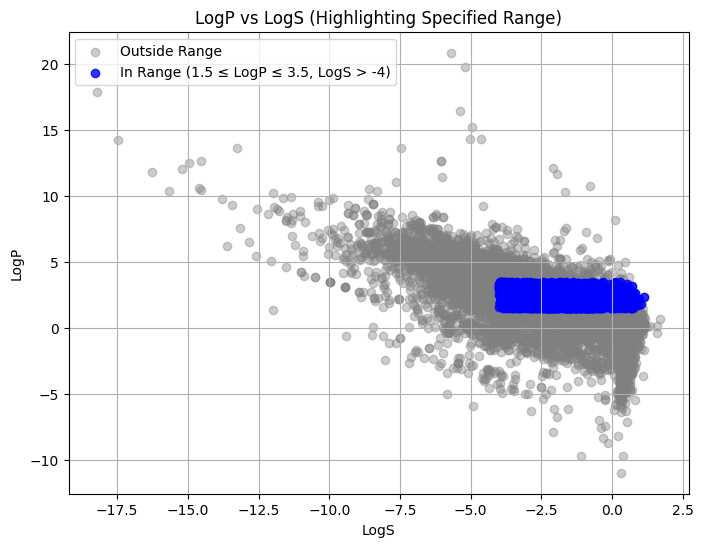

In [ ]:
import matplotlib.pyplot as plt

# Filter data points that fall within the specified range
highlighted_data = data[
    (data['logP'] >= 1.5) & (data['logP'] <= 3.5) &
    (data['logS'] > -4)
]

# Plot all data points
plt.figure(figsize=(8, 6))
plt.scatter(data['logS'], data['logP'], color='gray', alpha=0.4, label='Outside Range')  # Plot other points in gray

# Highlight the data points within the specified range
plt.scatter(highlighted_data['logS'], highlighted_data['logP'], color='blue', alpha=0.8, label='In Range (1.5 ≤ LogP ≤ 3.5, LogS > -4)')

# Add labels and title
plt.xlabel('LogS')  # X-axis label
plt.ylabel('LogP')  # Y-axis label
plt.title('LogP vs LogS (Highlighting Specified Range)')  # Plot title

# Add grid for better readability
plt.grid(True)

# Add legend to distinguish highlighted points
plt.legend(loc='upper left')

# Show the plot
plt.show()


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: False
Device name: No GPU detected


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('highlighted_molecules.csv')

# Define the logP and logS values as a tuple
log_values = df[['logP', 'logS']].apply(tuple, axis=1)

# Create a dictionary mapping log values to SMILES
log_to_smiles = dict(zip(log_values, df['SMILES']))

In [ ]:
# Assuming you have a DataFrame 'data' with a column 'SMILES'
# Extract the SMILES column as a list
# Convert to a Hugging Face Dataset
smiles_df = data[['SMILES']]
# data = Dataset.from_dict({"SMILES": data})

In [ ]:
# Convert the DataFrame to a Hugging Face Dataset
smiles_dataset = Dataset.from_pandas(smiles_df)

# Display the dataset
print(smiles_dataset)

Dataset({
    features: ['SMILES'],
    num_rows: 3527
})


In [ ]:
# Tokenizer and Model Setup
model_name = "ncfrey/ChemGPT-4.7M"
from transformers import RobertaTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

modelgpt = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Model vocab size: {modelgpt.config.vocab_size}")

Tokenizer vocab size: 684
Model vocab size: 684


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler

In [ ]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class SMILESDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        # Ensure data is a list of SMILES strings, not a DataFrame.
        if isinstance(data, list):
            self.data = data
        else:
            raise ValueError("Data must be a list of SMILES strings.")

        self.tokenizer = tokenizer
        self.max_length = max_length

        # Ensure tokenizer has a pad token, if not, use eos_token as pad_token
        if tokenizer.pad_token is None:
            # tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as pad_token if none is set
            # Alternatively, you can add a pad token:
            special_tokens = {"pad_token": "[PAD]", "bos_token": "<s>", "eos_token": "</s>"}
            tokenizer.add_special_tokens(special_tokens)

        # Print out tokenizer details for debugging
        print(f"Tokenizer vocab size: {len(self.tokenizer)}")
        print(f"Pad token: {self.tokenizer.pad_token}, eos token: {self.tokenizer.eos_token}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smile = self.data[idx]  # Get the SMILES string at the current index

        # Tokenize the SMILES string with padding and truncation to the max_length
        encoding = self.tokenizer(
            smile,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Ensure no token index exceeds the tokenizer's vocab size
        input_ids = encoding["input_ids"].squeeze(0)  # Remove batch dimension (index 0)
        attention_mask = encoding["attention_mask"].squeeze(0)  # Remove batch dimension (index 0)

        # Check if any input_id exceeds vocab size
        if any(id >= len(self.tokenizer) for id in input_ids):
            print(f"Warning: Token index exceeds vocab size for input: {smile}")

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }


In [ ]:
# Split the dataset into train and validation (80% train, 20% validation)
split_data = smiles_dataset.train_test_split(test_size=0.2, seed=42)

# Access the train and validation splits
train_dataset = split_data['train']
eval_dataset = split_data['test']

In [ ]:
train_dataset = train_dataset['SMILES']  # Assuming the 'train' split contains the SMILES column
eval_dataset = eval_dataset['SMILES']

In [ ]:
print(train_dataset)
print(type(train_dataset))  # Should be <class 'list'>
print(len(train_dataset))   # Should be greater than 0

print(train_dataset[1])

['CN(/N=N/c1ccc(cc1)C(=O)N)C', 'CCCC(C(=O)Nc1ncccn1)CCC', 'OC(CN1CCN(CC1)c1ccccc1)COc1cccc(c1)C(=O)C', 'CCC(C(=O)NC(=O)N)CC', 'CN1CC2CCC(C1)N2C(=O)c1ccccc1[N+](=O)[O-]', 'Clc1ccc(c(c1)Cl)N1C(=O)C2C(C1=O)C1OC2CC1', 'COC(c1cnc(n1C)[N+](=O)[O-])(C)C', 'OCC(=O)[C@@]1(O)CC[C@@H]2[C@]1(C)CC(=O)[C@H]1[C@H]2CCC2=CC(=O)CC[C@]12C', 'CCCCOCCNc1ccccc1C(=O)N', 'Oc1cccc(c1)Cl', 'CCN1C(C)(C)CCCC1(C)C', 'ClC[C@H](CBr)Br', 'CCC(c1ccccn1)C(=S)N.Cl', 'OCCNCCNc1ccc(c2c1C(=O)c1c(C2=O)c(O)ccc1O)NCCNCCO.Cl.Cl', 'Cl[C@@H](C(F)(F)F)Br', 'CNCC(COc1c(ccc(c1C(=O)OCC)C)C(C)C)O', 'OS(=O)(=O)O.COc1ccc2c3c1O[C@@H]1[C@@]43CCN([C@H](C2)[C@@H]4C=C[C@@H]1O)C.COc1ccc2c3c1O[C@@H]1[C@@]43CCN([C@H](C2)[C@@H]4C=C[C@@H]1O)C', 'CN(C1CN(C(=O)C1)c1ccccc1)CCc1ccccc1', 'Clc1ccc2c(c1)[nH]c(=O)o2', 'OC(COc1ccc(cc1)CC(=O)N)CNC(C)C\t', 'CCCC[C@@H](CN)CC', 'CCCCCC=C', 'OCc1cc2CCC(Nc2cc1[N+](=O)[O-])CNC(C)C', 'CN1CCC(C1)OC(=O)Nc1c(C)cccc1Cl', 'CCCC[N+](CC)(CC)CC.[OH-]', 'CN(C(=O)/C(=C(/c1ccccc1)\\C)/C)C', 'CCCCC[C@@H](CC)O', 'O=C(Nc1ccc(

In [ ]:
train_dataset = SMILESDataset(train_dataset, tokenizer)
val_dataset = SMILESDataset(eval_dataset, tokenizer)


# Create DataLoader for batching during training
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

Tokenizer vocab size: 686
Pad token: [PAD], eos token: </s>
Tokenizer vocab size: 686
Pad token: [PAD], eos token: </s>


In [ ]:
print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Model vocab size: {modelgpt.config.vocab_size}")

Tokenizer vocab size: 686
Model vocab size: 684


In [ ]:
modelgpt.resize_token_embeddings(len(tokenizer))
print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Model vocab size: {modelgpt.config.vocab_size}")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer vocab size: 686
Model vocab size: 686


In [ ]:
print(train_dataset)

In [ ]:
epochs = 1
# Optimizer and Scheduler
optimizer = AdamW(modelgpt.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

import torch
import torch.nn.functional as F

# Cross-entropy loss function (for language modeling)
def compute_loss(logits, labels):
    # Shift labels by 1 for causal LM (because we predict the next token)
    labels = labels[:, 1:].contiguous()  # Skip the first token for the labels
    logits = logits[:, :-1, :].contiguous()  # Skip the last token for the logits

    # Compute cross-entropy loss between logits and labels
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-100)
    return loss

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:


# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    modelgpt.train()
    total_train_loss = 0

    # Training Phase
    for batch in train_loader:
        # Move data to the correct device
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["input_ids"]  # Labels are the same as the input_ids for LM

        # Forward pass
        outputs = modelgpt(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"  Average Training Loss: {avg_train_loss:.4f}")

Epoch 1/1
  Average Training Loss: 0.0932


In [ ]:
import torch
from torch.utils.data import DataLoader

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in dataloader:
            input_ids = batch['input_ids']  # Move to correct device if necessary
            attention_mask = batch['attention_mask']
            labels = batch['input_ids']  # For sequence generation, labels can be the input_ids

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Compute total loss
            total_loss += loss.item()

            # Assuming a classification task (use argmax for prediction)
            # For sequence generation tasks, this part might differ based on your output structure
            predicted_ids = torch.argmax(logits, dim=-1)
            correct_predictions += (predicted_ids == labels).sum().item()
            total_predictions += labels.numel()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions * 100

    print(f"Evaluation loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy


# Run the evaluation
evaluate(modelgpt, val_loader)


Evaluation loss: 0.0710
Accuracy: 96.41%


(0.07099679927143766, 96.40691395184136)

In [ ]:
def generate_molecule(model, tokenizer, max_length=128):
    model.eval()  # Set the model to evaluation mode

    # Start token (e.g., <s> token)
    input_ids = tokenizer.encode("<s>C", return_tensors="pt")

    # Generate SMILES sequence
    generated_ids = model.generate(input_ids, max_length=max_length, num_return_sequences=1, pad_token_id=tokenizer.pad_token_id)

    # Decode the generated sequence
    generated_smiles = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_smiles



In [ ]:
generated_molecule = generate_molecule(modelgpt, tokenizer)
print("Generated Molecule:", generated_molecule)

Generated Molecule: C [#C-expl] [C] [#C-expl] [=NH2+expl] [N] [SHexpl] [#C-expl] [N] [N] [NH+expl] [P] [=NH+expl] [O] [NH+expl] [Cl+3expl] [#C-expl] [O] [NHexpl] [P] [Branch1_3] [C] [=N] [P] [=NH2+expl] [=NH2+expl] [=NH2+expl] [=NH2+expl] [=NH2+expl] [=NH2+expl] [=NH2+expl] [=NH2+expl] [=NH2+expl] [=NH2+expl] [=NH+expl] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C]
